<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Sentiment_analysis_for_Hotels_using_CV_and_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Data Exploration**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline





import itertools


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install catboost

     |████████████████████████████████| 65.9MB 65kB/s 


**Load Dataset**

In [ ]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Hotel Data1.csv to Hotel Data1.csv


In [ ]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Hotel Data1.csv']))

In [ ]:
data.head()

,Hotel_id,Hotel,Address,city,Title,Users,Reviews,Rating
0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,5
1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,5
2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,5
3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,7520 Teague Rd,Hanover,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,2
4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,7520 Teague Rd,Hanover,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,5


In [ ]:
# Print Multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

**Data** Exploration and Data Visualization 

In [ ]:
#Explore Data
data.shape
type(data)
data.size
data.shape
data.head()
data.tail()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Hotel_id  9999 non-null   object
 1   Hotel     9999 non-null   object
 2   Address   9999 non-null   object
 3   city      9999 non-null   object
 4   Title     9998 non-null   object
 5   Users     9999 non-null   object
 6   Reviews   9998 non-null   object
 7   Rating    9999 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 625.1+ KB


In [ ]:
# Ratings Count
data.Rating.value_counts()

5    4384
4    2901
3    1462
2     661
1     591
Name: Rating, dtype: int64

In [ ]:
print("Mean rating : {}".format(data['Rating'].mean()))
print("Mean rating standard deviation: {}".format(data['Rating'].std()))

Mean rating : 3.9826982698269826
Mean rating standard deviation: 1.1751071676401597


Text(0, 0.5, 'Count')

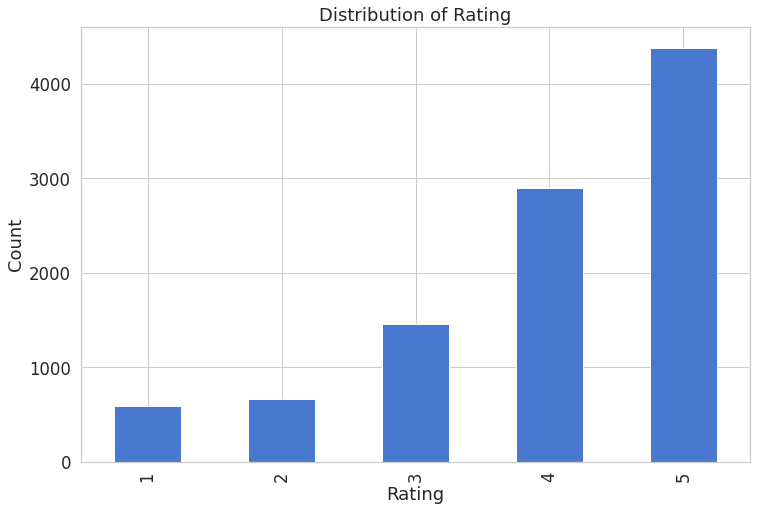

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0, 0.5, 'number of reviewers')

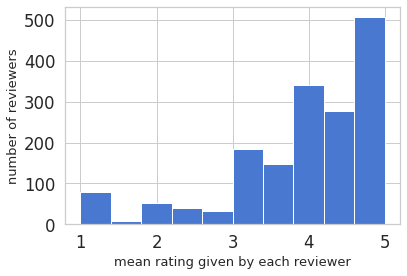

In [ ]:
mean_rating_of_user = data.groupby('Hotel').apply(lambda x: x['Rating'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [ ]:
# Dividing the Sentiment into "Positive" and "Negative" w.r.t to the Rating
data['Sentiment'] = data['Rating'].apply(lambda Rating: 'Positive' if Rating > 3 else 'Negative')
data.head(5)

,Hotel_id,Hotel,Address,city,Title,Users,Reviews,Rating,Sentiment
0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,5,Positive
1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,5,Positive
2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,5921 Valencia Cir,Rancho Santa Fe,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,5,Positive
3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,7520 Teague Rd,Hanover,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,2,Negative
4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,7520 Teague Rd,Hanover,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,5,Positive


In [ ]:
# Sentiment Count
data.Sentiment.value_counts()


Positive    7285
Negative    2714
Name: Sentiment, dtype: int64

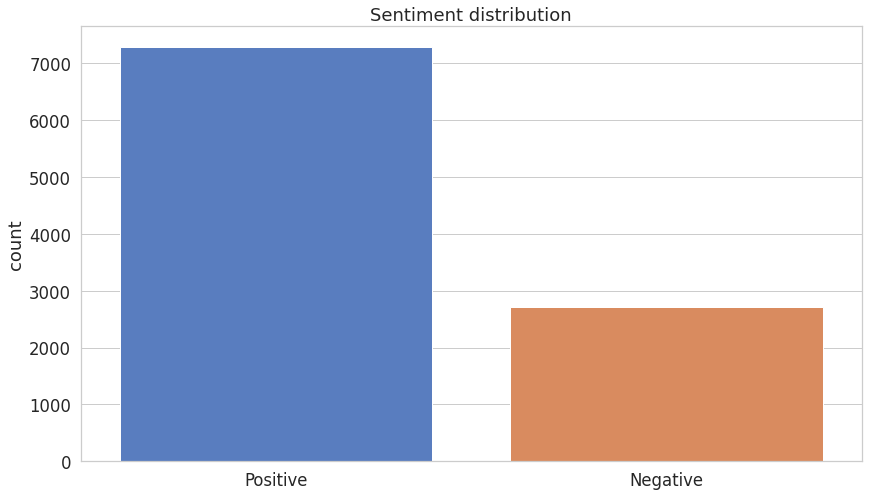

In [ ]:
# Plot Showing Sentiment Distribution
f = sns.countplot(x='Sentiment', data=data)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Positive', 'Negative'])
plt.xlabel("");

In [ ]:
#Check for missing value
pd.isnull(data).any()
pd.isnull(data).sum()

Hotel_id     0
Hotel        0
Address      0
city         0
Title        1
Users        0
Reviews      1
Rating       0
Sentiment    0
dtype: int64

In [ ]:
data['Reviews'] = data['Reviews'].fillna('').apply(str)

In [ ]:
positive_sentiment=data[data['Sentiment'] == 'Positive']
negative_sentiment=data[data['Sentiment']=='Negative']

In [ ]:

Reviews_all=" ".join(review for review in data.Sentiment)
Reviews_positive=" ".join(review for review in positive_sentiment.Reviews)


In [ ]:
Reviews_negative=" ".join(review for review in negative_sentiment.Reviews)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


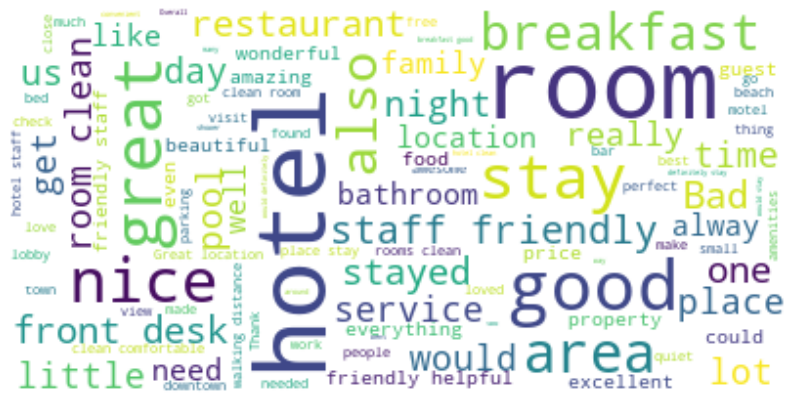

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(Reviews_positive)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


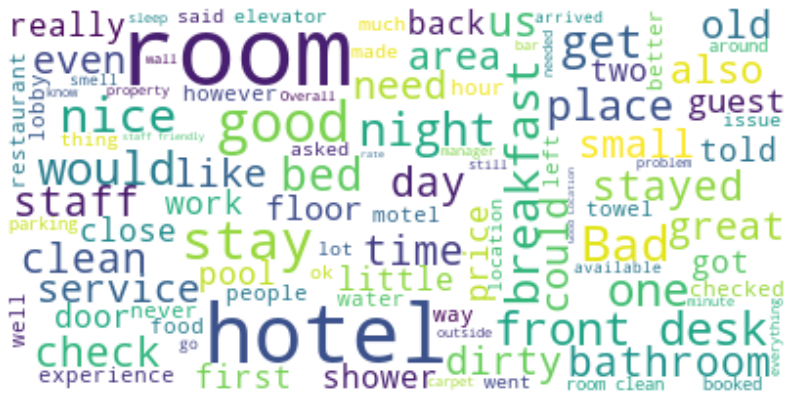

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(Reviews_negative)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

3. **Text Processing**

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

1.remove Punctuations 

2.Tokenization and Lematization

3.convert to lower case

4.remove stop words such as "the" and "and" if needed










In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Reviews'].apply(lambda x: remove_punct(x))

In [ ]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [ ]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [ ]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [ ]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [ ]:
result = [' '.join(sen) for sen in filtered_words]

In [ ]:
data['Text_Clean'] = result

In [ ]:
# Showing the Review of index "3" after the text pre-processing
result[3]

'currently bed writing past hr 12 dogs barking squealing call front desk advise basically told theres nothing 31500 cant sleep'

In [ ]:
data['tokens'] = filtered_words


In [ ]:
data = data[['Hotel_id','Hotel','Title','Users','Reviews','Text_Clean', 'Rating','tokens','Sentiment']]
data.head(5)

,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"[experience, rancho, valencia, absolutely, per...",Positive
1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"[amazing, place, everyone, extremely, warm, we...",Positive
2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"[booked, 3, night, stay, rancho, valencia, pla...",Positive
3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"[currently, bed, writing, past, hr, 12, dogs, ...",Negative
4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"[live, md, aloft, home, away, homewe, stayed, ...",Positive


In [ ]:
# The "Positive" Sentiment has been labelled as "1" and the "Negative" as "0"
data['Label'] = data['Sentiment'].apply(lambda Sentiment: '1' if Sentiment is 'Positive' else '0')
data.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,Label
0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"[experience, rancho, valencia, absolutely, per...",Positive,1
1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"[amazing, place, everyone, extremely, warm, we...",Positive,1
2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"[booked, 3, night, stay, rancho, valencia, pla...",Positive,1
3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"[currently, bed, writing, past, hr, 12, dogs, ...",Negative,0
4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"[live, md, aloft, home, away, homewe, stayed, ...",Positive,1


Splitting Dataset into Train and Test Set¶
**bold text**

In [ ]:
# Splitting the Data Set into Train and Test Sets
X = data['Text_Clean']
y = data['Label']

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(7999,)
Test Set Shape		:(2000,)


**Confusion Matrix Plot Function**


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'Positive' and 'Negative' Sentiments 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [ ]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

**4.Modelling**


This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

Since the ratings of the reviews were not distributed normally, I decided to decrease rating classes from 5 to 2 by merging Rating 1-2-3 as 'Negative' and Rating 4-5 as 'Positive'.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

4.1 CountVectorizer Bag of Words¶

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class

In [ ]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [ ]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 17433


In [ ]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [ ]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,0130,034,06,0930,10,100,1000,10000,1000pm,1000s,1005pm,100716,100am,100n,100pm,100year,101,1011,1012,1015,1015am,1015min,102,103,1030,1030pm,1030pmon,1045am,105,1050,107,107f,108,109,10am,10day,10f,10k,10min,10mins,...,åß,åßáèó,åßëâø,åã,åå,åæ,åæâæìê,åæêñ,åæêó,åè,åêä,åñ,åñêàë,åò,åó,åô,åõ,åø,åøáæéâë,åøáöüë,åù,åü,æøâà,çß,çâ,çå,çç,ççëâø,çì,çí,çø,éà,éä,éé,éï,éñ,éõ,éû,éü,êñü
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Creating a function for applying different algorithms¶


In [ ]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

**Dummy Classifier**


In [ ]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.6081613479024175


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.28      0.28       545
           1       0.73      0.73      0.73      1455

    accuracy                           0.61      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.61      0.61      0.61      2000



**Logistic Regression with CountVectorizer**

In [ ]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8418429686819129


Classification Report¶


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72       545
           1       0.91      0.86      0.89      1455

    accuracy                           0.84      2000
   macro avg       0.79      0.82      0.81      2000
weighted avg       0.85      0.84      0.84      2000



Confusion Matrix¶


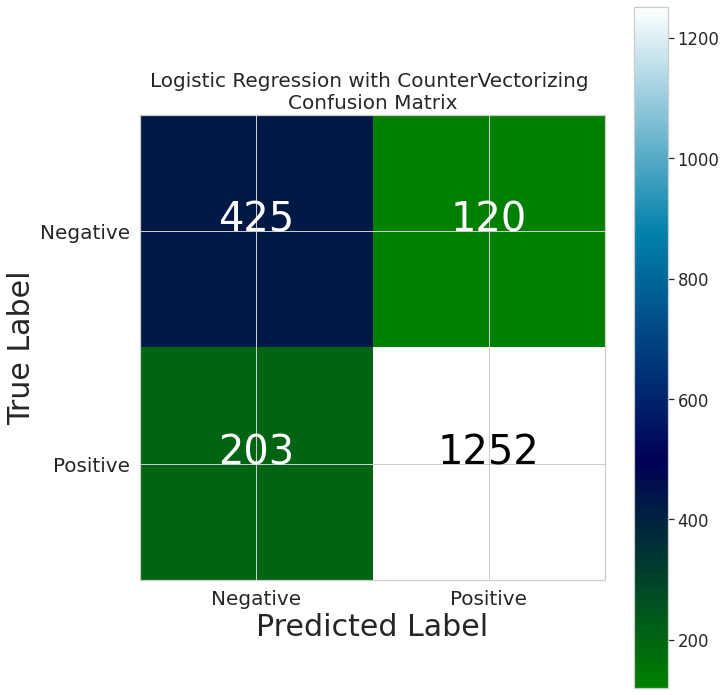

In [ ]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

**Random Forest with CountVectorizer**

In [ ]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8105738852863917


Classification Report¶


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.88      0.44      0.59       545
           1       0.82      0.98      0.89      1455

    accuracy                           0.83      2000
   macro avg       0.85      0.71      0.74      2000
weighted avg       0.84      0.83      0.81      2000



Confusion Matrix¶
**bold text**

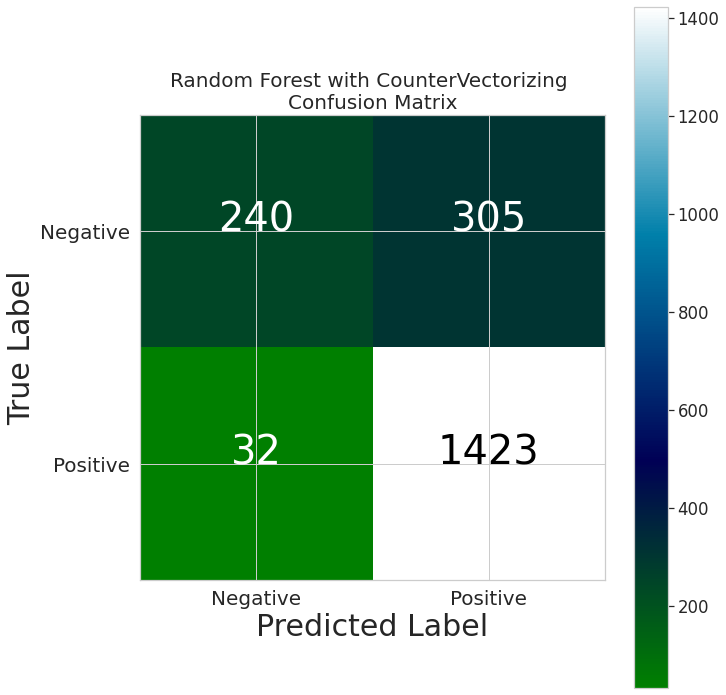

In [ ]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

**Naive Bayes with CountVectorizer**

In [ ]:
from sklearn.naive_bayes import MultinomialNB


In [ ]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.839534619854681


Classification Report¶


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       545
           1       0.87      0.93      0.90      1455

    accuracy                           0.84      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.84      0.84      0.84      2000



Confusion Matrix¶


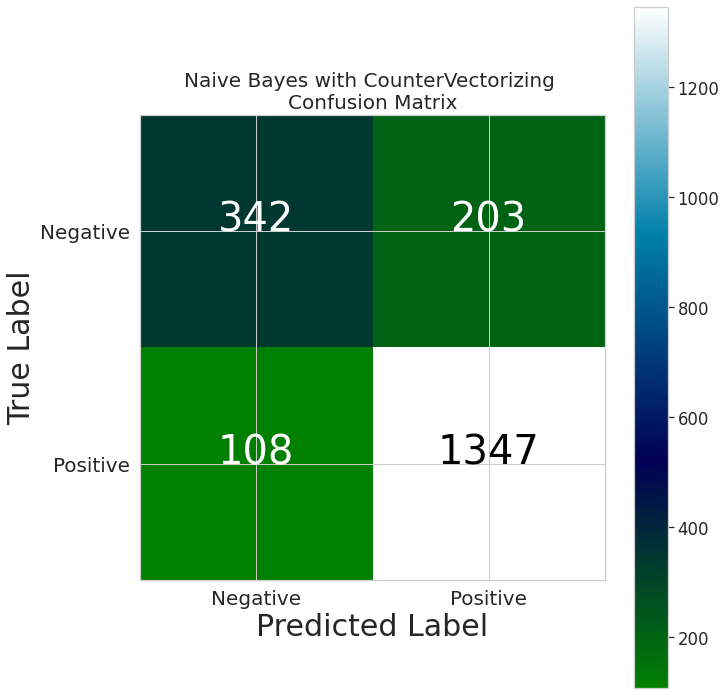

In [ ]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

**XG Boost with CountVectorizer**

In [ ]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.7889545739277887


Classification Report¶


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.86      0.39      0.53       545
           1       0.81      0.98      0.89      1455

    accuracy                           0.82      2000
   macro avg       0.83      0.68      0.71      2000
weighted avg       0.82      0.82      0.79      2000



Confusion Matrix¶


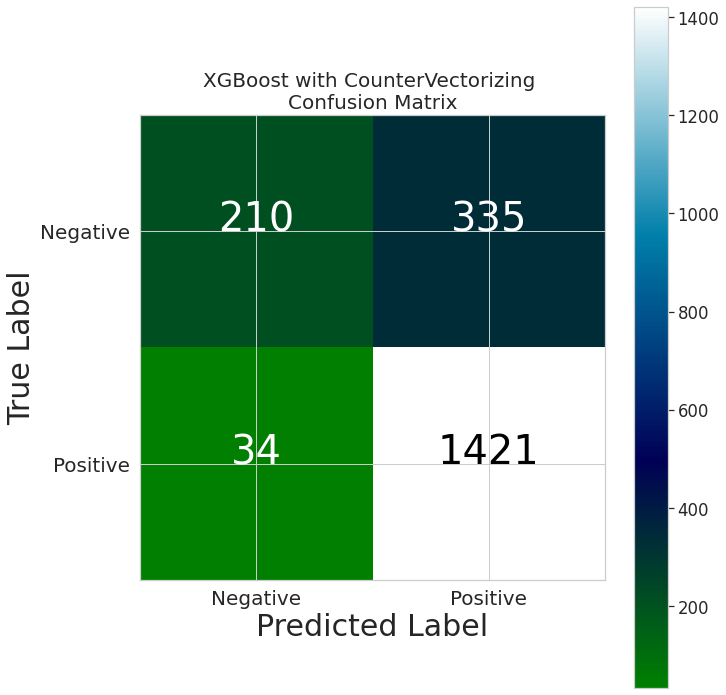

In [ ]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

**CatBoost with CountVectorizer**

In [ ]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.5443313	total: 73.8ms	remaining: 7.3s
1:	learn: 0.5266651	total: 95.3ms	remaining: 4.67s
2:	learn: 0.5081049	total: 116ms	remaining: 3.75s
3:	learn: 0.4969617	total: 138ms	remaining: 3.31s
4:	learn: 0.4849794	total: 158ms	remaining: 3.01s
5:	learn: 0.4771671	total: 179ms	remaining: 2.81s
6:	learn: 0.4686969	total: 201ms	remaining: 2.67s
7:	learn: 0.4604295	total: 222ms	remaining: 2.55s
8:	learn: 0.4523533	total: 244ms	remaining: 2.47s
9:	learn: 0.4449249	total: 265ms	remaining: 2.38s
10:	learn: 0.4393986	total: 291ms	remaining: 2.35s
11:	learn: 0.4343600	total: 313ms	remaining: 2.29s
12:	learn: 0.4290733	total: 334ms	remaining: 2.24s
13:	learn: 0.4238144	total: 356ms	remaining: 2.18s
14:	learn: 0.4198820	total: 377ms	remaining: 2.13s
15:	learn: 0.4151732	total: 400ms	remaining: 2.1s
16:	learn: 0.4100106	total: 425ms	remaining: 2.07s
17:	learn: 0.4073177	total: 455ms	remaining: 2.07s
18:	learn: 0.4043862	total: 479ms	remaining: 2.04s
19:	learn: 0.4006044	total: 506ms	remaini

Classification Report¶


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.78      0.55      0.65       545
           1       0.85      0.94      0.89      1455

    accuracy                           0.84      2000
   macro avg       0.82      0.75      0.77      2000
weighted avg       0.83      0.84      0.83      2000



Confusion Matrix¶


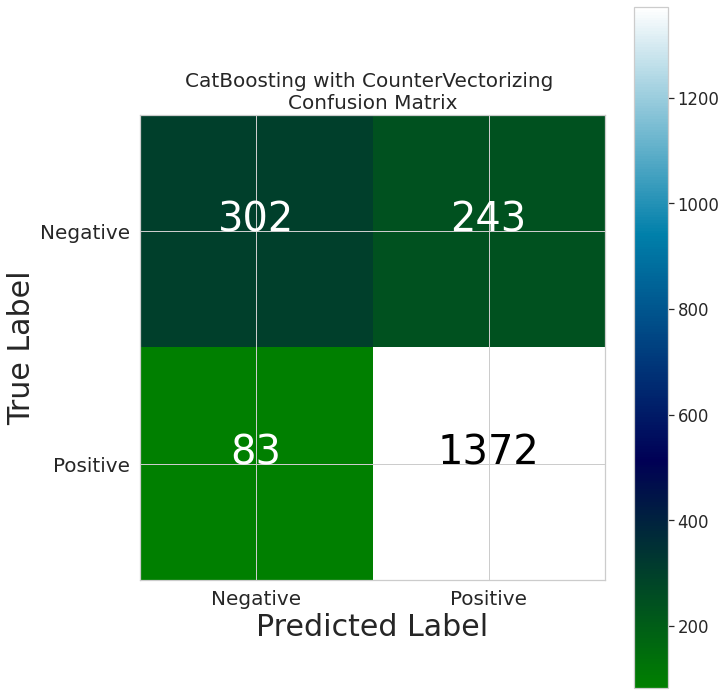

In [ ]:

# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

Comparison of Models with CountVectorizer
**bold text**

In [ ]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [ ]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])
   



Function for f1 Score Plotting¶
**bold text**

In [ ]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

In [ ]:
from sklearn import metrics


In [ ]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])
               

In [ ]:
df_tv2

precision  ...  support
vectorizer model         accuracy class               ...         
CountVect  LogReg        0.8385   bad       0.676752  ...    545.0
                                  good      0.912536  ...   1455.0
                                  average   0.848285  ...   2000.0
           Random Forest 0.8315   bad       0.882353  ...    545.0
                                  good      0.823495  ...   1455.0
                                  average   0.839534  ...   2000.0
           Naive Bayes   0.8445   bad       0.760000  ...    545.0
                                  good      0.869032  ...   1455.0
                                  average   0.839321  ...   2000.0
           XGBoost       0.8155   bad       0.860656  ...    545.0
                                  good      0.809226  ...   1455.0
                                  average   0.823240  ...   2000.0
           CatBoost      0.8370   bad       0.784416  ...    545.0
                                  good      0.849536  ...   1455.0
                                  average   0.831790  ...   2000.0

[15 rows x 4 columns]

Average f1 Score - Models with CountVectorizer¶
**bold text**

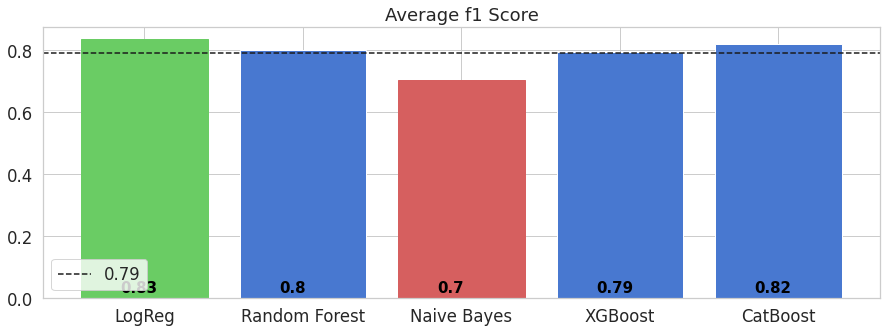

In [ ]:

# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

In [ ]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [ ]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8345136724378227


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.64      0.83      0.73       545
           1       0.93      0.83      0.88      1455

    accuracy                           0.83      2000
   macro avg       0.79      0.83      0.80      2000
weighted avg       0.85      0.83      0.83      2000



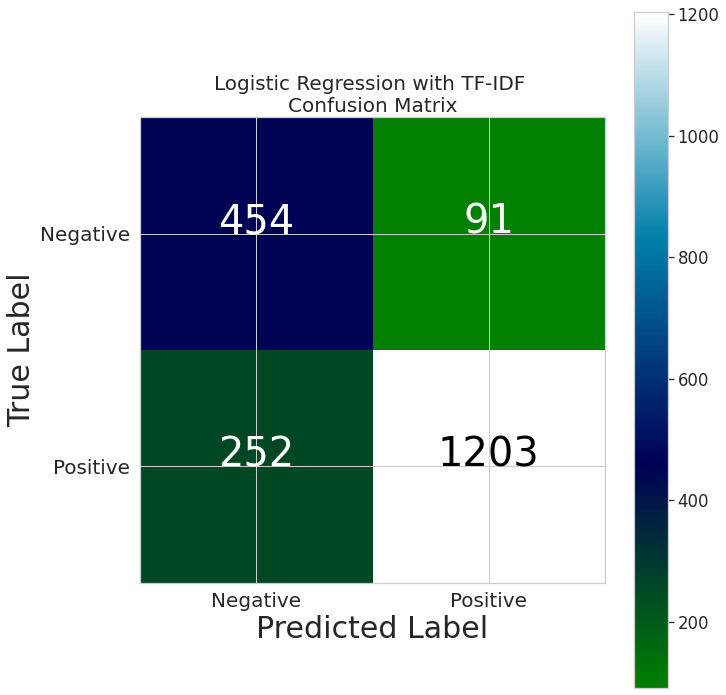

In [ ]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

Random Forest with TF-IDF¶


In [ ]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.801092866437951


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.90      0.41      0.56       545
           1       0.82      0.98      0.89      1455

    accuracy                           0.83      2000
   macro avg       0.86      0.69      0.73      2000
weighted avg       0.84      0.83      0.80      2000



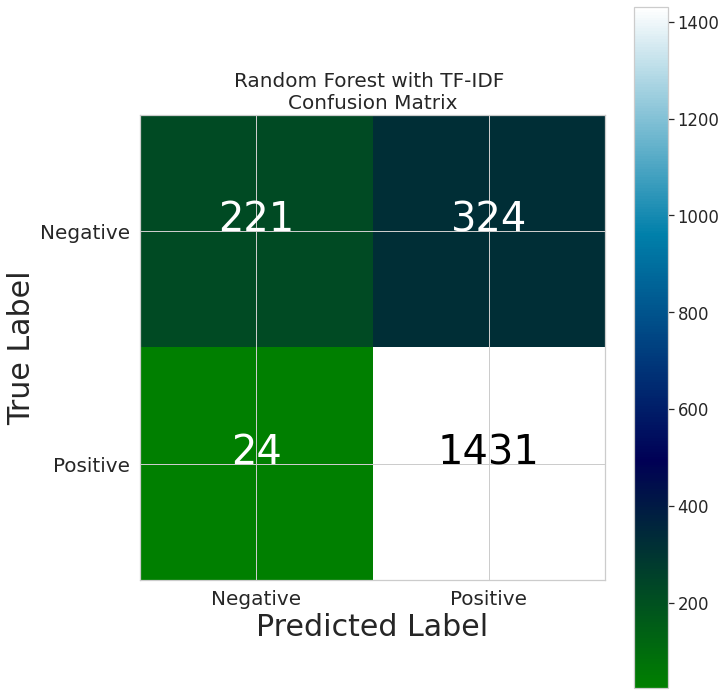

In [ ]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

**Naive Bayes with TF-IDF**

In [ ]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.7047184581099172


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.98      0.16      0.28       545
           1       0.76      1.00      0.86      1455

    accuracy                           0.77      2000
   macro avg       0.87      0.58      0.57      2000
weighted avg       0.82      0.77      0.70      2000



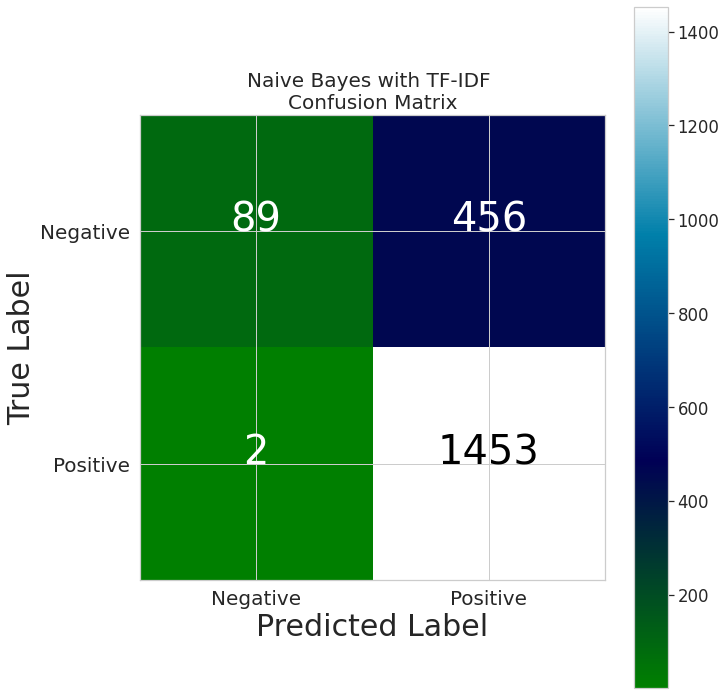

In [ ]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

**XGBoost with TF-IDF**

In [ ]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.7924562208462159


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.89      0.39      0.54       545
           1       0.81      0.98      0.89      1455

    accuracy                           0.82      2000
   macro avg       0.85      0.68      0.71      2000
weighted avg       0.83      0.82      0.79      2000



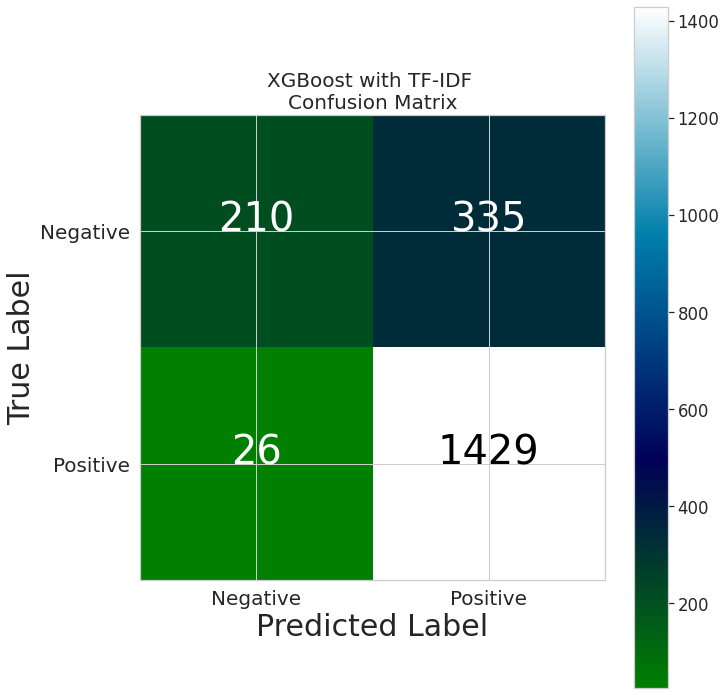

In [ ]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

**CatBoost with TF-IDF**

In [ ]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.5450730	total: 63.2ms	remaining: 6.25s
1:	learn: 0.5226426	total: 114ms	remaining: 5.61s
2:	learn: 0.5106694	total: 165ms	remaining: 5.34s
3:	learn: 0.4994960	total: 216ms	remaining: 5.18s
4:	learn: 0.4888301	total: 269ms	remaining: 5.11s
5:	learn: 0.4782319	total: 319ms	remaining: 5s
6:	learn: 0.4678848	total: 369ms	remaining: 4.91s
7:	learn: 0.4602587	total: 420ms	remaining: 4.83s
8:	learn: 0.4520483	total: 470ms	remaining: 4.75s
9:	learn: 0.4453996	total: 522ms	remaining: 4.7s
10:	learn: 0.4396651	total: 580ms	remaining: 4.69s
11:	learn: 0.4334093	total: 630ms	remaining: 4.62s
12:	learn: 0.4274559	total: 683ms	remaining: 4.57s
13:	learn: 0.4232926	total: 734ms	remaining: 4.51s
14:	learn: 0.4184569	total: 785ms	remaining: 4.45s
15:	learn: 0.4134666	total: 840ms	remaining: 4.41s
16:	learn: 0.4089276	total: 894ms	remaining: 4.37s
17:	learn: 0.4057225	total: 944ms	remaining: 4.3s
18:	learn: 0.4028064	total: 996ms	remaining: 4.25s
19:	learn: 0.3992692	total: 1.04s	remaining: 

In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       545
           1       0.85      0.93      0.89      1455

    accuracy                           0.83      2000
   macro avg       0.80      0.74      0.76      2000
weighted avg       0.82      0.83      0.82      2000



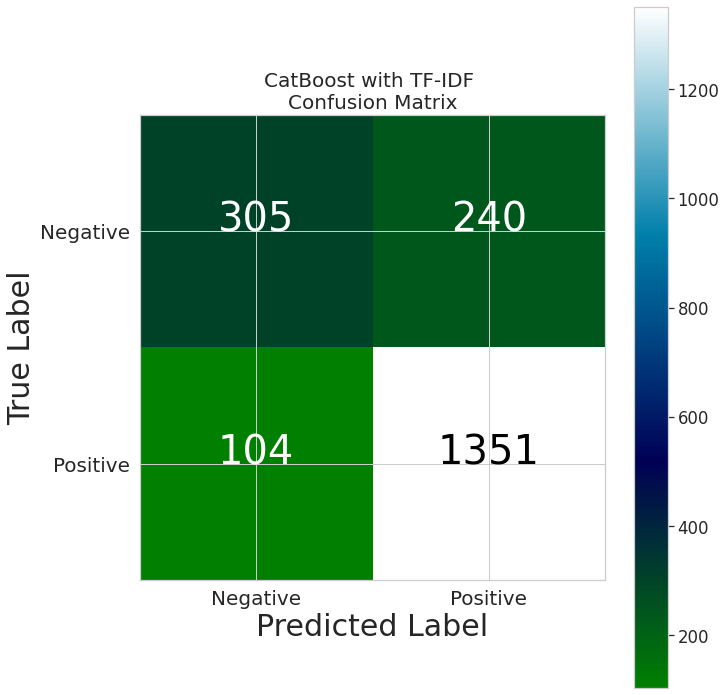

In [ ]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

In [ ]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [ ]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision  ...  support
vectorizer model         accuracy class               ...         
CountVect  LogReg        0.8285   bad       0.643059  ...    545.0
                                  good      0.929675  ...   1455.0
                                  average   0.851573  ...   2000.0
           Random Forest 0.8260   bad       0.902041  ...    545.0
                                  good      0.815385  ...   1455.0
                                  average   0.838998  ...   2000.0
           Naive Bayes   0.7710   bad       0.978022  ...    545.0
                                  good      0.761131  ...   1455.0
                                  average   0.820234  ...   2000.0
           XGBoost       0.8195   bad       0.889831  ...    545.0
                                  good      0.810091  ...   1455.0
                                  average   0.831820  ...   2000.0
           CatBoost      0.8280   bad       0.745721  ...    545.0
                                  good      0.849151  ...   1455.0
                                  average   0.820967  ...   2000.0

[15 rows x 4 columns]

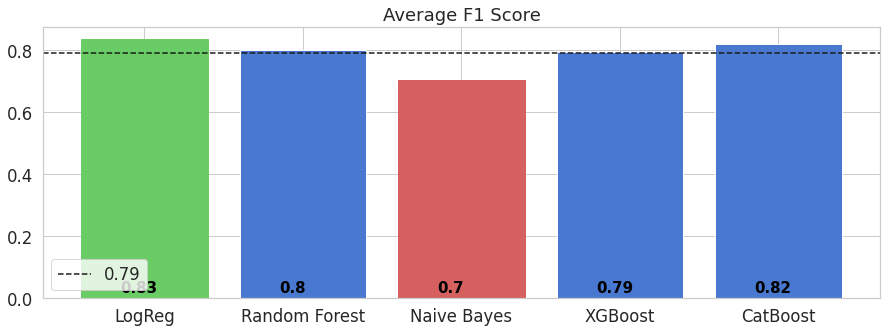

In [ ]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")